In [40]:
%pip install tabulate -qqq

Note: you may need to restart the kernel to use updated packages.


### Read the history files with metrics

In [41]:
import os
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error


history_path = '../data/history/'
catboost_preds_path = 'catboost_best_model.pkl'
average_preds_path = 'baseline_average.pickle'

In [42]:
catboost_preds = {}
with open(os.path.join(history_path, catboost_preds_path), 'rb') as f:
    catboost_preds = pickle.load(f)

average_preds = {}
with open(os.path.join(history_path, average_preds_path), 'rb') as f:
    average_preds = pickle.load(f)

In [43]:
history = {}
metrics = {}

experiments = [
    'transfomers_single_bert_mse',
    'transfomers_single_bert_huber',
    'transfomers_dual_bert_mse',
    'transfomers_double_bert_huber_tsdae',
    'transfomers_single_bert_huber_multilingual_e5_small',
    'transfomers_single_bert_cross_attention_huber',
    'transfomers_single_bert_cross_attention_huber_e5',
]

for experiment in experiments:
    with open(os.path.join(history_path, experiment + '.pickle'), 'rb') as f:
        history[experiment] = pickle.load(f)

# iterate over experiments, for each experiment iterate over seeds
# for each seed, make a new key y_pred_combined, where y_pred is averaged with catboost y_pred for the seed
# calculate metrics for the combined predictions as well
for experiment, experiment_history in history.items():
    for seed, seed_history in experiment_history.items():
        # assert y_test == catboost_preds[seed]['y_test'].  account for the small margin of error acceptable
        np.testing.assert_almost_equal(seed_history['y_test'][0], catboost_preds[seed]['y_test'], decimal=5)
        np.testing.assert_almost_equal(seed_history['y_test'][9], catboost_preds[seed]['y_test'], decimal=5)
        y_pred_catboost = catboost_preds[seed]['y_pred']
        seed_history['y_pred_catboost'] = y_pred_catboost
        # get metrics for catboost predictions
        r2 = [r2_score(seed_history['y_test'][i], y_pred_catboost) for i in range(10)]
        mae = [mean_absolute_error(seed_history['y_test'][i], y_pred_catboost) for i in range(10)]
        rmse = [root_mean_squared_error(seed_history['y_test'][i], y_pred_catboost) for i in range(10)]

        seed_history['r2_catboost'] = r2
        seed_history['mae_catboost'] = mae
        seed_history['rmse_catboost'] = rmse

        # average each epoch prediction with catboost prediction. use numpy for speed
        y_pred_combined = (np.array(seed_history['y_pred']) + catboost_preds[seed]['y_pred']) / 2
        seed_history['y_pred_combined'] = y_pred_combined

        # get metrics for the combined predictions
        r2 = [r2_score(seed_history['y_test'][i], y_pred_combined[i]) for i in range(10)]
        mae = [mean_absolute_error(seed_history['y_test'][i], y_pred_combined[i]) for i in range(10)]
        rmse = [root_mean_squared_error(seed_history['y_test'][i], y_pred_combined[i]) for i in range(10)]
        seed_history['r2_combined'] = r2
        seed_history['mae_combined'] = mae
        seed_history['rmse_combined'] = rmse


### History parsing

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t


def mean_confidence_interval(data, confidence=0.95):
        n = len(data)
        m, se = np.mean(data), np.std(data) / np.sqrt(n)
        h = se * t.ppf((1 + confidence) / 2, n-1)
        return m, m-h, m+h


def display_metrics_with_ci(history: dict):
    # plot mean and ci for train and test r2 for all seeds and all iterations, averaged over seeds
    seeds = list(history.keys())

    r2_train_values = [history[seed]['train_r2'] for seed in seeds]
    r2_test_values = [history[seed]['test_r2'] for seed in seeds]

    r2_train_values = np.array(r2_train_values)
    r2_test_values = np.array(r2_test_values)

    r2_train_mean = np.mean(r2_train_values, axis=0)
    r2_test_mean = np.mean(r2_test_values, axis=0)

    r2_train_ci = np.array([mean_confidence_interval(r2_train_values[:, i]) for i in range(r2_train_values.shape[1])])
    r2_test_ci = np.array([mean_confidence_interval(r2_test_values[:, i]) for i in range(r2_test_values.shape[1])])

    plt.figure(figsize=(10, 6))
    # make x from 1 to the end (not from 0), because the first epoch is usually an outlier
    # plt.plot(r2_train_mean[1:], label='train')
    plt.plot(range(2, len(r2_train_mean) + 1), r2_train_mean[1:], label='train')
        # r2_train_mean[1:], label='train')
    plt.fill_between(range(2, len(r2_train_mean) + 1), r2_train_ci[1:, 1], r2_train_ci[1:, 2], alpha=0.3)

    plt.plot(range(2, len(r2_test_mean) + 1), r2_test_mean[1:], label='test')
    plt.fill_between(range(2, len(r2_test_mean) + 1), r2_test_ci[1:, 1], r2_test_ci[1:, 2], alpha=0.3)
    plt.title('Mean R2 by epoch, with 95% CI')
    plt.xlabel('Epoch')
    plt.ylabel('R2')
    plt.legend()
    plt.show()

    mae_test_values = [history[seed]['test_mae'] for seed in seeds]
    rmse_test_values = [history[seed]['test_rmse'] for seed in seeds]

    mae_test_values = np.array(mae_test_values)
    rmse_test_values = np.array(rmse_test_values)

    mae_test_mean = np.mean(mae_test_values, axis=0)
    rmse_test_mean = np.mean(rmse_test_values, axis=0)

    mae_test_ci = np.array([mean_confidence_interval(mae_test_values[:, i]) for i in range(mae_test_values.shape[1])])
    rmse_test_ci = np.array([mean_confidence_interval(rmse_test_values[:, i]) for i in range(rmse_test_values.shape[1])])

    # get an index of the epoch, where the test R2 is the highest
    # get mean and CI for this epoch
    best_epoch = np.argmax(r2_test_mean)
    best_epoch_r2 = r2_test_mean[best_epoch]
    best_epoch_mae = mae_test_mean[best_epoch]
    best_epoch_rmse = rmse_test_mean[best_epoch]
    best_epoch_r2_ci = r2_test_ci[best_epoch]
    best_epoch_mae_ci = mae_test_ci[best_epoch]
    best_epoch_rmse_ci = rmse_test_ci[best_epoch]


    # create a dict with keys = experiment (transformer for this one), columns = epoch (best), mean, ci_low, ci_high for each metric for the best epoch
    metrics_df = {}
    metrics_df['transformer'] = {}
    metrics_df['transformer']['r2_mean'] = best_epoch_r2
    metrics_df['transformer']['r2_ci_low'] = best_epoch_r2_ci[1]
    metrics_df['transformer']['r2_ci_high'] = best_epoch_r2_ci[2]
    metrics_df['transformer']['mae_mean'] = best_epoch_mae
    metrics_df['transformer']['mae_ci_low'] = best_epoch_mae_ci[1]
    metrics_df['transformer']['mae_ci_high'] = best_epoch_mae_ci[2]
    metrics_df['transformer']['rmse_mean'] = best_epoch_rmse
    metrics_df['transformer']['rmse_ci_low'] = best_epoch_rmse_ci[1]
    metrics_df['transformer']['rmse_ci_high'] = best_epoch_rmse_ci[2]
    metrics_df['transformer']['best_epoch'] = best_epoch


    print()
    print(f'TEST METRICS FOR THE BEST EPOCH (#{best_epoch+1})')
    print(f'R2: mean = {best_epoch_r2:.4f}, 95% CI = [{best_epoch_r2_ci[1]:.4f}, {best_epoch_r2_ci[2]:.4f}]')
    print(f'MAE: mean = {best_epoch_mae:.4f}, 95% CI = [{best_epoch_mae_ci[1]:.4f}, {best_epoch_mae_ci[2]:.4f}]')
    print(f'RMSE: mean = {best_epoch_rmse:.4f}, 95% CI = [{best_epoch_rmse_ci[1]:.4f}, {best_epoch_rmse_ci[2]:.4f}]')
    print()


    # same for combined predictions
    r2_test_values = [history[seed]['r2_catboost'] for seed in seeds]

    r2_test_values = np.array(r2_test_values)

    r2_test_mean = np.mean(r2_test_values, axis=0)

    r2_test_ci = np.array([mean_confidence_interval(r2_test_values[:, i]) for i in range(r2_test_values.shape[1])])

    mae_test_values = [history[seed]['mae_catboost'] for seed in seeds]
    rmse_test_values = [history[seed]['rmse_catboost'] for seed in seeds]

    mae_test_values = np.array(mae_test_values)
    rmse_test_values = np.array(rmse_test_values)

    mae_test_mean = np.mean(mae_test_values, axis=0)
    rmse_test_mean = np.mean(rmse_test_values, axis=0)

    mae_test_ci = np.array([mean_confidence_interval(mae_test_values[:, i]) for i in range(mae_test_values.shape[1])])
    rmse_test_ci = np.array([mean_confidence_interval(rmse_test_values[:, i]) for i in range(rmse_test_values.shape[1])])

    # get an index of the epoch, where the test R2 is the highest
    # get mean and CI for this epoch
    best_epoch = np.argmax(r2_test_mean)
    best_epoch_r2 = r2_test_mean[best_epoch]
    best_epoch_mae = mae_test_mean[best_epoch]
    best_epoch_rmse = rmse_test_mean[best_epoch]
    best_epoch_r2_ci = r2_test_ci[best_epoch]
    best_epoch_mae_ci = mae_test_ci[best_epoch]
    best_epoch_rmse_ci = rmse_test_ci[best_epoch]


    metrics_df['catboost'] = {}
    metrics_df['catboost']['r2_mean'] = best_epoch_r2
    metrics_df['catboost']['r2_ci_low'] = best_epoch_r2_ci[1]
    metrics_df['catboost']['r2_ci_high'] = best_epoch_r2_ci[2]
    metrics_df['catboost']['mae_mean'] = best_epoch_mae
    metrics_df['catboost']['mae_ci_low'] = best_epoch_mae_ci[1]
    metrics_df['catboost']['mae_ci_high'] = best_epoch_mae_ci[2]
    metrics_df['catboost']['rmse_mean'] = best_epoch_rmse
    metrics_df['catboost']['rmse_ci_low'] = best_epoch_rmse_ci[1]
    metrics_df['catboost']['rmse_ci_high'] = best_epoch_rmse_ci[2]
    metrics_df['catboost']['best_epoch'] = best_epoch

    print()
    print(f'CATBOOST ONLY. TEST METRICS FOR THE BEST EPOCH (#{best_epoch+1})')
    print(f'R2: mean = {best_epoch_r2:.4f}, 95% CI = [{best_epoch_r2_ci[1]:.4f}, {best_epoch_r2_ci[2]:.4f}]')
    print(f'MAE: mean = {best_epoch_mae:.4f}, 95% CI = [{best_epoch_mae_ci[1]:.4f}, {best_epoch_mae_ci[2]:.4f}]')
    print(f'RMSE: mean = {best_epoch_rmse:.4f}, 95% CI = [{best_epoch_rmse_ci[1]:.4f}, {best_epoch_rmse_ci[2]:.4f}]')
    print()



    # same for combined predictions
    r2_test_values = [history[seed]['r2_combined'] for seed in seeds]

    r2_test_values = np.array(r2_test_values)

    r2_test_mean = np.mean(r2_test_values, axis=0)

    r2_test_ci = np.array([mean_confidence_interval(r2_test_values[:, i]) for i in range(r2_test_values.shape[1])])

    mae_test_values = [history[seed]['mae_combined'] for seed in seeds]
    rmse_test_values = [history[seed]['rmse_combined'] for seed in seeds]

    mae_test_values = np.array(mae_test_values)
    rmse_test_values = np.array(rmse_test_values)

    mae_test_mean = np.mean(mae_test_values, axis=0)
    rmse_test_mean = np.mean(rmse_test_values, axis=0)

    mae_test_ci = np.array([mean_confidence_interval(mae_test_values[:, i]) for i in range(mae_test_values.shape[1])])
    rmse_test_ci = np.array([mean_confidence_interval(rmse_test_values[:, i]) for i in range(rmse_test_values.shape[1])])

    # get an index of the epoch, where the test R2 is the highest
    # get mean and CI for this epoch
    best_epoch = np.argmax(r2_test_mean)
    best_epoch_r2 = r2_test_mean[best_epoch]
    best_epoch_mae = mae_test_mean[best_epoch]
    best_epoch_rmse = rmse_test_mean[best_epoch]
    best_epoch_r2_ci = r2_test_ci[best_epoch]
    best_epoch_mae_ci = mae_test_ci[best_epoch]
    best_epoch_rmse_ci = rmse_test_ci[best_epoch]


    metrics_df['combined'] = {}
    metrics_df['combined']['r2_mean'] = best_epoch_r2
    metrics_df['combined']['r2_ci_low'] = best_epoch_r2_ci[1]
    metrics_df['combined']['r2_ci_high'] = best_epoch_r2_ci[2]
    metrics_df['combined']['mae_mean'] = best_epoch_mae
    metrics_df['combined']['mae_ci_low'] = best_epoch_mae_ci[1]
    metrics_df['combined']['mae_ci_high'] = best_epoch_mae_ci[2]
    metrics_df['combined']['rmse_mean'] = best_epoch_rmse
    metrics_df['combined']['rmse_ci_low'] = best_epoch_rmse_ci[1]
    metrics_df['combined']['rmse_ci_high'] = best_epoch_rmse_ci[2]
    metrics_df['combined']['best_epoch'] = best_epoch

    print()
    print(f'COMBINED WITH CATBOOST. TEST METRICS FOR THE BEST EPOCH (#{best_epoch+1})')
    print(f'R2: mean = {best_epoch_r2:.4f}, 95% CI = [{best_epoch_r2_ci[1]:.4f}, {best_epoch_r2_ci[2]:.4f}]')
    print(f'MAE: mean = {best_epoch_mae:.4f}, 95% CI = [{best_epoch_mae_ci[1]:.4f}, {best_epoch_mae_ci[2]:.4f}]')
    print(f'RMSE: mean = {best_epoch_rmse:.4f}, 95% CI = [{best_epoch_rmse_ci[1]:.4f}, {best_epoch_rmse_ci[2]:.4f}]')
    print()

    # transform the dict into a dataframe
    metrics_df = pd.DataFrame(metrics_df)
    # transpose the dataframe
    metrics_df = metrics_df.T
    metrics_df.index.name = 'experiment'
    

    return metrics_df

### Visualize the results

TRANSFOMERS_SINGLE_BERT_MSE


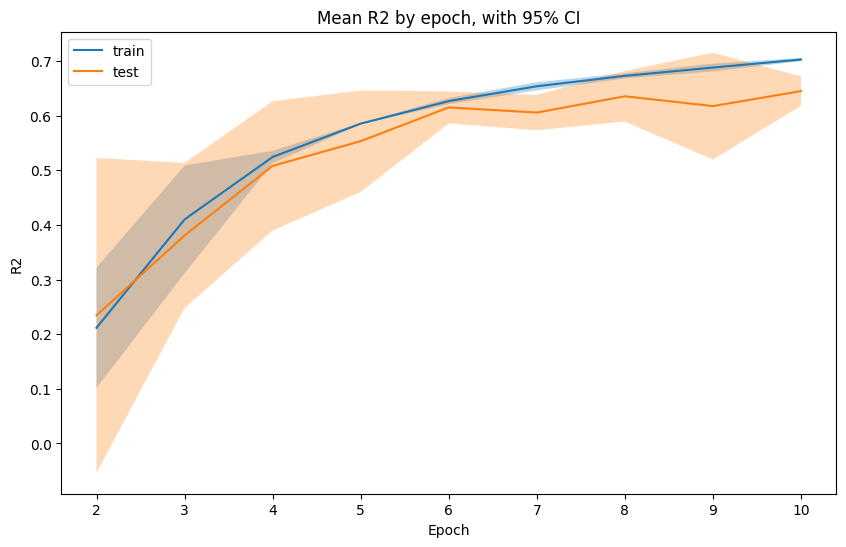


TEST METRICS FOR THE BEST EPOCH (#10)
R2: mean = 0.6449, 95% CI = [0.6181, 0.6717]
MAE: mean = 0.2893, 95% CI = [0.2769, 0.3017]
RMSE: mean = 0.3745, 95% CI = [0.3611, 0.3879]


CATBOOST ONLY. TEST METRICS FOR THE BEST EPOCH (#1)
R2: mean = 0.7341, 95% CI = [0.7288, 0.7395]
MAE: mean = 0.2476, 95% CI = [0.2431, 0.2521]
RMSE: mean = 0.3241, 95% CI = [0.3214, 0.3268]


COMBINED WITH CATBOOST. TEST METRICS FOR THE BEST EPOCH (#10)
R2: mean = 0.7336, 95% CI = [0.7226, 0.7447]
MAE: mean = 0.2473, 95% CI = [0.2405, 0.2540]
RMSE: mean = 0.3244, 95% CI = [0.3183, 0.3305]

             r2_mean  r2_ci_low  r2_ci_high  r2_diff
experiment                                          
transformer    0.645      0.618       0.672    0.054
catboost       0.734      0.729       0.739    0.011
combined       0.734      0.723       0.745    0.022

             mae_mean  mae_ci_low  mae_ci_high  mae_diff
experiment                                              
transformer     0.289       0.277        0.302  

In [45]:
experiment = 'transfomers_single_bert_mse'
print(experiment.upper())
print('='*100)


metrics[experiment] = display_metrics_with_ci(history[experiment])
metrics[experiment]['r2_diff'] = metrics[experiment]['r2_ci_high'] - metrics[experiment]['r2_ci_low']
metrics[experiment]['mae_diff'] = metrics[experiment]['mae_ci_high'] - metrics[experiment]['mae_ci_low']

print(metrics[experiment][['r2_mean', 'r2_ci_low', 'r2_ci_high', 'r2_diff',]].round(3))
print()
print(metrics[experiment][['mae_mean', 'mae_ci_low', 'mae_ci_high', 'mae_diff']].round(3))

TRANSFOMERS_DUAL_BERT_MSE


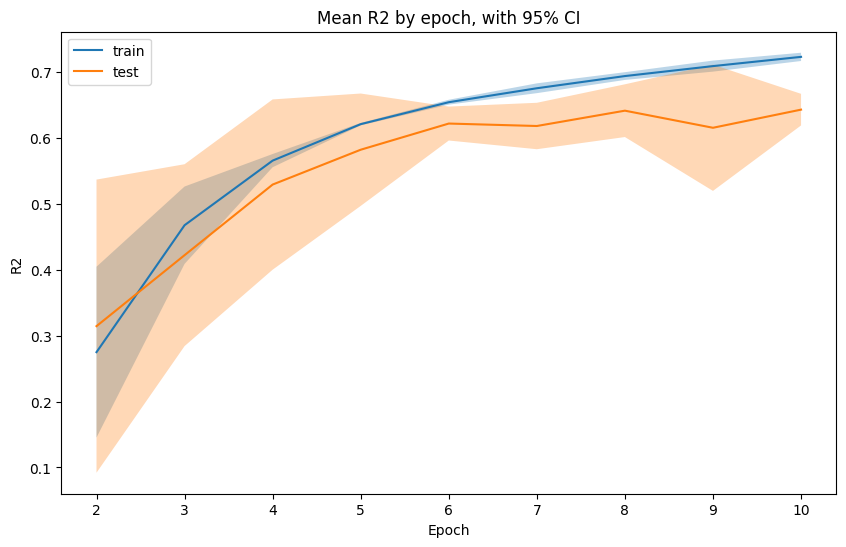


TEST METRICS FOR THE BEST EPOCH (#10)
R2: mean = 0.6428, 95% CI = [0.6188, 0.6668]
MAE: mean = 0.2912, 95% CI = [0.2783, 0.3041]
RMSE: mean = 0.3756, 95% CI = [0.3638, 0.3875]


CATBOOST ONLY. TEST METRICS FOR THE BEST EPOCH (#1)
R2: mean = 0.7341, 95% CI = [0.7288, 0.7395]
MAE: mean = 0.2476, 95% CI = [0.2431, 0.2521]
RMSE: mean = 0.3241, 95% CI = [0.3214, 0.3268]


COMBINED WITH CATBOOST. TEST METRICS FOR THE BEST EPOCH (#10)
R2: mean = 0.7347, 95% CI = [0.7247, 0.7448]
MAE: mean = 0.2469, 95% CI = [0.2402, 0.2535]
RMSE: mean = 0.3237, 95% CI = [0.3182, 0.3293]

             r2_mean  r2_ci_low  r2_ci_high  r2_diff
experiment                                          
transformer    0.643      0.619       0.667    0.048
catboost       0.734      0.729       0.739    0.011
combined       0.735      0.725       0.745    0.020

             mae_mean  mae_ci_low  mae_ci_high  mae_diff
experiment                                              
transformer     0.291       0.278        0.304  

In [46]:
experiment = 'transfomers_dual_bert_mse'
print(experiment.upper())
print('='*100)


metrics[experiment] = display_metrics_with_ci(history[experiment])
metrics[experiment]['r2_diff'] = metrics[experiment]['r2_ci_high'] - metrics[experiment]['r2_ci_low']
metrics[experiment]['mae_diff'] = metrics[experiment]['mae_ci_high'] - metrics[experiment]['mae_ci_low']

print(metrics[experiment][['r2_mean', 'r2_ci_low', 'r2_ci_high', 'r2_diff',]].round(3))
print()
print(metrics[experiment][['mae_mean', 'mae_ci_low', 'mae_ci_high', 'mae_diff']].round(3))

TRANSFOMERS_SINGLE_BERT_HUBER


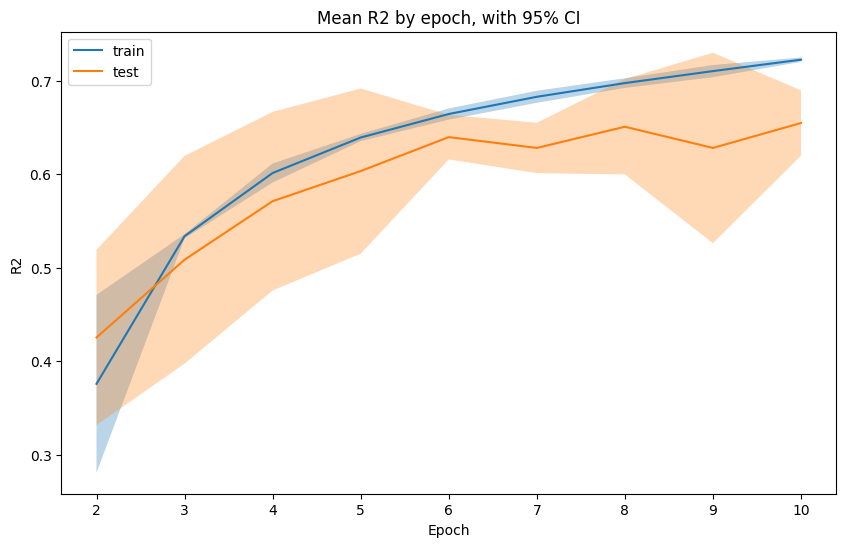


TEST METRICS FOR THE BEST EPOCH (#10)
R2: mean = 0.6546, 95% CI = [0.6198, 0.6894]
MAE: mean = 0.2856, 95% CI = [0.2692, 0.3019]
RMSE: mean = 0.3693, 95% CI = [0.3515, 0.3872]


CATBOOST ONLY. TEST METRICS FOR THE BEST EPOCH (#1)
R2: mean = 0.7341, 95% CI = [0.7288, 0.7395]
MAE: mean = 0.2476, 95% CI = [0.2431, 0.2521]
RMSE: mean = 0.3241, 95% CI = [0.3214, 0.3268]


COMBINED WITH CATBOOST. TEST METRICS FOR THE BEST EPOCH (#10)
R2: mean = 0.7378, 95% CI = [0.7252, 0.7504]
MAE: mean = 0.2454, 95% CI = [0.2377, 0.2530]
RMSE: mean = 0.3218, 95% CI = [0.3147, 0.3290]

             r2_mean  r2_ci_low  r2_ci_high  r2_diff
experiment                                          
transformer    0.655      0.620       0.689    0.070
catboost       0.734      0.729       0.739    0.011
combined       0.738      0.725       0.750    0.025

             mae_mean  mae_ci_low  mae_ci_high  mae_diff
experiment                                              
transformer     0.286       0.269        0.302  

In [47]:
experiment = 'transfomers_single_bert_huber'
print(experiment.upper())
print('='*100)

metrics[experiment] = display_metrics_with_ci(history[experiment])
metrics[experiment]['r2_diff'] = metrics[experiment]['r2_ci_high'] - metrics[experiment]['r2_ci_low']
metrics[experiment]['mae_diff'] = metrics[experiment]['mae_ci_high'] - metrics[experiment]['mae_ci_low']

print(metrics[experiment][['r2_mean', 'r2_ci_low', 'r2_ci_high', 'r2_diff',]].round(3))
print()
print(metrics[experiment][['mae_mean', 'mae_ci_low', 'mae_ci_high', 'mae_diff']].round(3))

TRANSFOMERS_DOUBLE_BERT_HUBER_TSDAE


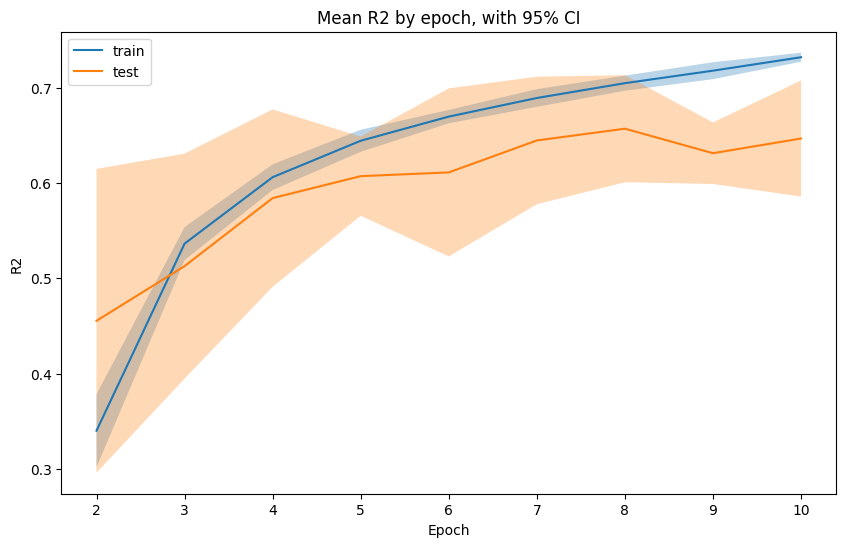


TEST METRICS FOR THE BEST EPOCH (#8)
R2: mean = 0.6570, 95% CI = [0.6008, 0.7131]
MAE: mean = 0.2848, 95% CI = [0.2612, 0.3084]
RMSE: mean = 0.3679, 95% CI = [0.3375, 0.3984]


CATBOOST ONLY. TEST METRICS FOR THE BEST EPOCH (#1)
R2: mean = 0.7341, 95% CI = [0.7288, 0.7395]
MAE: mean = 0.2476, 95% CI = [0.2431, 0.2521]
RMSE: mean = 0.3241, 95% CI = [0.3214, 0.3268]


COMBINED WITH CATBOOST. TEST METRICS FOR THE BEST EPOCH (#8)
R2: mean = 0.7378, 95% CI = [0.7256, 0.7500]
MAE: mean = 0.2456, 95% CI = [0.2387, 0.2526]
RMSE: mean = 0.3218, 95% CI = [0.3139, 0.3298]

             r2_mean  r2_ci_low  r2_ci_high  r2_diff
experiment                                          
transformer    0.657      0.601       0.713    0.112
catboost       0.734      0.729       0.739    0.011
combined       0.738      0.726       0.750    0.024

             mae_mean  mae_ci_low  mae_ci_high  mae_diff
experiment                                              
transformer     0.285       0.261        0.308    

In [48]:
experiment = 'transfomers_double_bert_huber_tsdae'
print(experiment.upper())
print('='*100)


metrics[experiment] = display_metrics_with_ci(history[experiment])
metrics[experiment]['r2_diff'] = metrics[experiment]['r2_ci_high'] - metrics[experiment]['r2_ci_low']
metrics[experiment]['mae_diff'] = metrics[experiment]['mae_ci_high'] - metrics[experiment]['mae_ci_low']

print(metrics[experiment][['r2_mean', 'r2_ci_low', 'r2_ci_high', 'r2_diff',]].round(3))
print()
print(metrics[experiment][['mae_mean', 'mae_ci_low', 'mae_ci_high', 'mae_diff']].round(3))

TRANSFOMERS_SINGLE_BERT_HUBER_MULTILINGUAL_E5_SMALL


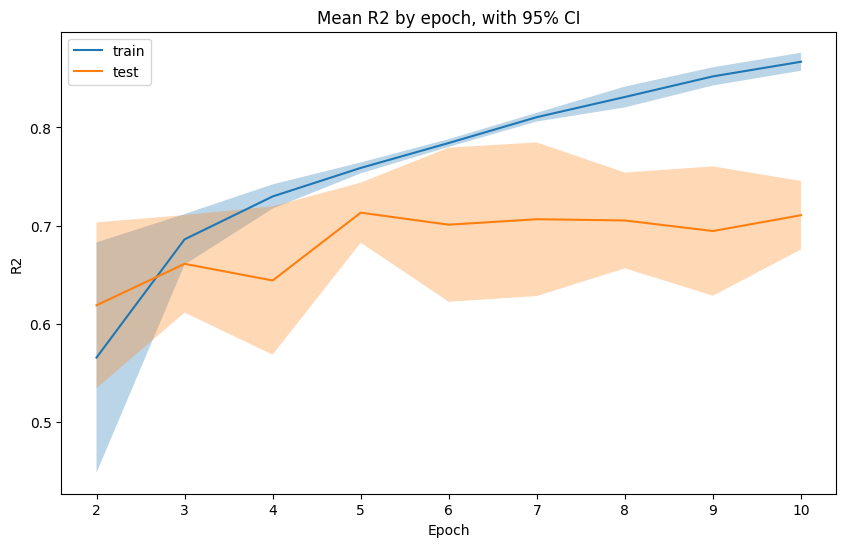


TEST METRICS FOR THE BEST EPOCH (#5)
R2: mean = 0.7132, 95% CI = [0.6827, 0.7438]
MAE: mean = 0.2585, 95% CI = [0.2479, 0.2692]
RMSE: mean = 0.3365, 95% CI = [0.3184, 0.3547]


CATBOOST ONLY. TEST METRICS FOR THE BEST EPOCH (#1)
R2: mean = 0.7341, 95% CI = [0.7288, 0.7395]
MAE: mean = 0.2476, 95% CI = [0.2431, 0.2521]
RMSE: mean = 0.3241, 95% CI = [0.3214, 0.3268]


COMBINED WITH CATBOOST. TEST METRICS FOR THE BEST EPOCH (#10)
R2: mean = 0.7698, 95% CI = [0.7615, 0.7781]
MAE: mean = 0.2288, 95% CI = [0.2230, 0.2345]
RMSE: mean = 0.3016, 95% CI = [0.2967, 0.3064]

             r2_mean  r2_ci_low  r2_ci_high  r2_diff
experiment                                          
transformer    0.713      0.683       0.744    0.061
catboost       0.734      0.729       0.739    0.011
combined       0.770      0.762       0.778    0.017

             mae_mean  mae_ci_low  mae_ci_high  mae_diff
experiment                                              
transformer     0.259       0.248        0.269   

In [49]:
experiment = 'transfomers_single_bert_huber_multilingual_e5_small'
print(experiment.upper())
print('='*100)


metrics[experiment] = display_metrics_with_ci(history[experiment])
metrics[experiment]['r2_diff'] = metrics[experiment]['r2_ci_high'] - metrics[experiment]['r2_ci_low']
metrics[experiment]['mae_diff'] = metrics[experiment]['mae_ci_high'] - metrics[experiment]['mae_ci_low']

print(metrics[experiment][['r2_mean', 'r2_ci_low', 'r2_ci_high', 'r2_diff',]].round(3))
print()
print(metrics[experiment][['mae_mean', 'mae_ci_low', 'mae_ci_high', 'mae_diff']].round(3))

TRANSFOMERS_SINGLE_BERT_CROSS_ATTENTION_HUBER


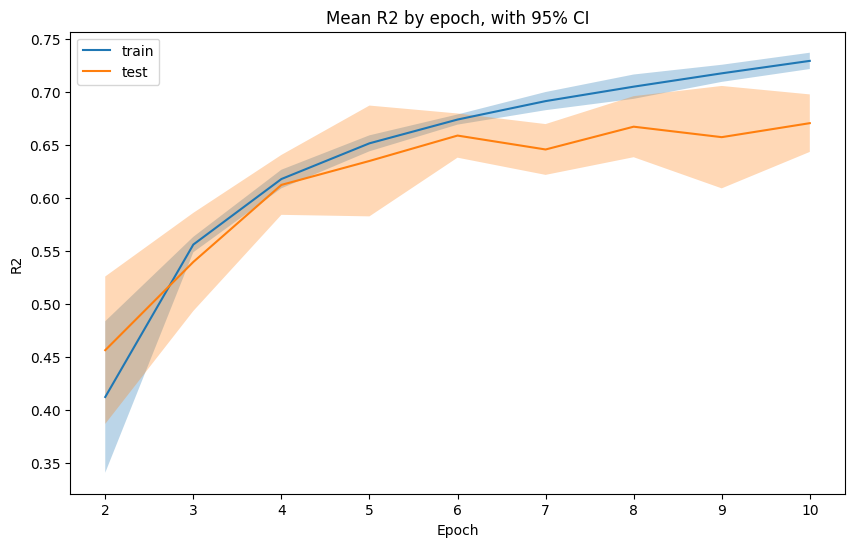


TEST METRICS FOR THE BEST EPOCH (#10)
R2: mean = 0.6709, 95% CI = [0.6437, 0.6980]
MAE: mean = 0.2790, 95% CI = [0.2648, 0.2933]
RMSE: mean = 0.3606, 95% CI = [0.3455, 0.3756]


CATBOOST ONLY. TEST METRICS FOR THE BEST EPOCH (#1)
R2: mean = 0.7341, 95% CI = [0.7288, 0.7395]
MAE: mean = 0.2476, 95% CI = [0.2431, 0.2521]
RMSE: mean = 0.3241, 95% CI = [0.3214, 0.3268]


COMBINED WITH CATBOOST. TEST METRICS FOR THE BEST EPOCH (#10)
R2: mean = 0.7420, 95% CI = [0.7348, 0.7493]
MAE: mean = 0.2434, 95% CI = [0.2377, 0.2492]
RMSE: mean = 0.3192, 95% CI = [0.3147, 0.3238]

             r2_mean  r2_ci_low  r2_ci_high  r2_diff
experiment                                          
transformer    0.671      0.644       0.698    0.054
catboost       0.734      0.729       0.739    0.011
combined       0.742      0.735       0.749    0.015

             mae_mean  mae_ci_low  mae_ci_high  mae_diff
experiment                                              
transformer     0.279       0.265        0.293  

In [50]:
# now for the last one
experiment = 'transfomers_single_bert_cross_attention_huber'
print(experiment.upper())
print('='*100)


metrics[experiment] = display_metrics_with_ci(history[experiment])
metrics[experiment]['r2_diff'] = metrics[experiment]['r2_ci_high'] - metrics[experiment]['r2_ci_low']
metrics[experiment]['mae_diff'] = metrics[experiment]['mae_ci_high'] - metrics[experiment]['mae_ci_low']

print(metrics[experiment][['r2_mean', 'r2_ci_low', 'r2_ci_high', 'r2_diff',]].round(3))
print()
print(metrics[experiment][['mae_mean', 'mae_ci_low', 'mae_ci_high', 'mae_diff']].round(3))


TRANSFOMERS_SINGLE_BERT_CROSS_ATTENTION_HUBER_E5


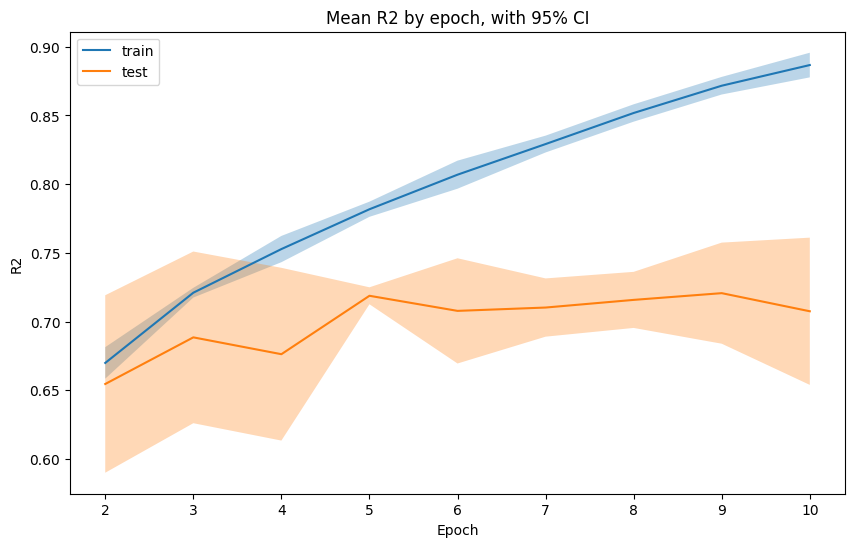


TEST METRICS FOR THE BEST EPOCH (#9)
R2: mean = 0.7207, 95% CI = [0.6839, 0.7575]
MAE: mean = 0.2553, 95% CI = [0.2369, 0.2736]
RMSE: mean = 0.3321, 95% CI = [0.3110, 0.3531]


CATBOOST ONLY. TEST METRICS FOR THE BEST EPOCH (#1)
R2: mean = 0.7341, 95% CI = [0.7288, 0.7395]
MAE: mean = 0.2476, 95% CI = [0.2431, 0.2521]
RMSE: mean = 0.3241, 95% CI = [0.3214, 0.3268]


COMBINED WITH CATBOOST. TEST METRICS FOR THE BEST EPOCH (#9)
R2: mean = 0.7717, 95% CI = [0.7605, 0.7828]
MAE: mean = 0.2279, 95% CI = [0.2212, 0.2347]
RMSE: mean = 0.3003, 95% CI = [0.2936, 0.3071]

             r2_mean  r2_ci_low  r2_ci_high  r2_diff
experiment                                          
transformer    0.721      0.684       0.757    0.074
catboost       0.734      0.729       0.739    0.011
combined       0.772      0.761       0.783    0.022

             mae_mean  mae_ci_low  mae_ci_high  mae_diff
experiment                                              
transformer     0.255       0.237        0.274    

In [51]:
# now for the last one
experiment = 'transfomers_single_bert_cross_attention_huber_e5'
print(experiment.upper())
print('='*100)


metrics[experiment] = display_metrics_with_ci(history[experiment])
metrics[experiment]['r2_diff'] = metrics[experiment]['r2_ci_high'] - metrics[experiment]['r2_ci_low']
metrics[experiment]['mae_diff'] = metrics[experiment]['mae_ci_high'] - metrics[experiment]['mae_ci_low']

print(metrics[experiment][['r2_mean', 'r2_ci_low', 'r2_ci_high', 'r2_diff',]].round(3))
print()
print(metrics[experiment][['mae_mean', 'mae_ci_low', 'mae_ci_high', 'mae_diff']].round(3))


### Create a summary table

In [77]:
from copy import deepcopy

# make a deep copy of the original dictionary
metrics_ = deepcopy(metrics)

experiments_name_dict = {
    'transfomers_single_bert_mse': 'Single rubert-tiny-turbo (29M), MSE loss',
    'transfomers_single_bert_huber': 'Single rubert-tiny-turbo (29M), Huber loss',
    'transfomers_dual_bert_mse': 'Dual rubert-tiny-turbo (29M), MSE loss',
    'transfomers_double_bert_huber_tsdae': 'Double rubert-tiny-turbo (29M), Huber loss, TSDAE',
    'transfomers_single_bert_huber_multilingual_e5_small': 'Single multilingual-e5-small (118M), Huber loss',
    'transfomers_single_bert_cross_attention_huber': 'Single rubert-tiny-turbo, Huber loss, cross-attention',
    'transfomers_single_bert_cross_attention_huber_e5': 'Single multilingual-e5-small, Huber loss, cross-attention',
}

# now merge all experiments metrics into a single dataframe
# add each experiment name by concatenating it with the experiment name
for experiment, df in metrics_.items():
    df: pd.DataFrame
    # reset the index, keep the old index as a column
    # make new index with the experiment name
    df.reset_index(inplace=True)
    df.rename(columns={'experiment': 'type'}, inplace=True)
    df['experiment'] = experiments_name_dict[experiment]
    df.set_index('experiment', inplace=True)

    # concatenate the experiment name with the metric name
    # df.index = df.index.map(lambda x: experiments_name_dict[experiment] + ' ' + x)

metrics_df = pd.concat(metrics_.values())
# make columns r2, mae, rmse, have format str(mean +- (CI_high - mean))
# 1. make a new column with the difference between mean and CI_high
# 2. make a new column with the string representation of the mean and the difference
# 3. concatenate the strings
metrics_df['r2_ci_high_minus_r2_mean'] = metrics_df['r2_ci_high'] - metrics_df['r2_mean']
# 2. make a new column with the string representation of the mean and the difference
# use symbol '±' for the plus-minus sign
# if the last digit is 0, it should be still displayed
metrics_df['r2'] = metrics_df['r2_mean'].round(3).astype(str) + ' ± ' + metrics_df['r2_ci_high_minus_r2_mean'].round(3).astype(str)
# same for mae
metrics_df['mae_ci_high_minus_mae_mean'] = metrics_df['mae_ci_high'] - metrics_df['mae_mean']
metrics_df['mae'] = metrics_df['mae_mean'].round(3).astype(str) + ' ± ' + metrics_df['mae_ci_high_minus_mae_mean'].round(3).astype(str)

# same for rmse
metrics_df['rmse_ci_high_minus_rmse_mean'] = metrics_df['rmse_ci_high'] - metrics_df['rmse_mean']
metrics_df['rmse'] = metrics_df['rmse_mean'].round(3).astype(str) + ' ± ' + metrics_df['rmse_ci_high_minus_rmse_mean'].round(3).astype(str)

# reset the index (experiment), keep the old index as a column
metrics_df.reset_index(inplace=True, drop=False)


# now add average predictions
r2_by_average = [average_preds[seed]['test_r2'] for seed in average_preds.keys()]
mae_by_average = [average_preds[seed]['test_mae'] for seed in average_preds.keys()]
rmse_by_average = [average_preds[seed]['test_rmse'] for seed in average_preds.keys()]

r2_mean_by_average, r2_low_by_average, r2_high_by_average = mean_confidence_interval(r2_by_average)
r2_diff_by_average = r2_high_by_average - r2_mean_by_average
mae_mean_by_average, mae_low_by_average, mae_high_by_average = mean_confidence_interval(mae_by_average)
mae_diff_by_average = mae_high_by_average - mae_mean_by_average
rmse_mean_by_average, rmse_low_by_average, rmse_high_by_average = mean_confidence_interval(rmse_by_average)
rmse_diff_by_average = rmse_high_by_average - rmse_mean_by_average

# add average predictions +- CI to the dataframe
# first, make a new df
average_df = pd.DataFrame({
    'experiment': 'Average',
    'type': 'average',
    'r2': f'{r2_mean_by_average:.3f} ± {r2_diff_by_average:.3f}',
    'mae': f'{mae_mean_by_average:.3f} ± {mae_diff_by_average:.3f}',
    'rmse': f'{rmse_mean_by_average:.3f} ± {rmse_diff_by_average:.3f}'
}, index=[0])

# add the average predictions to the dataframe
metrics_df = pd.concat([metrics_df, average_df])

# reset the index
metrics_df.reset_index(drop=True, inplace=True)

# print  markdown table

print(metrics_df[['experiment', 'type', 'r2', 'mae',]].to_markdown(index=False))

| experiment                                                | type        | r2             | mae           |
|:----------------------------------------------------------|:------------|:---------------|:--------------|
| Single rubert-tiny-turbo (29M), MSE loss                  | transformer | 0.645 ± 0.027  | 0.289 ± 0.012 |
| Single rubert-tiny-turbo (29M), MSE loss                  | catboost    | 0.734 ± 0.005  | 0.248 ± 0.004 |
| Single rubert-tiny-turbo (29M), MSE loss                  | combined    | 0.734 ± 0.011  | 0.247 ± 0.007 |
| Dual rubert-tiny-turbo (29M), MSE loss                    | transformer | 0.643 ± 0.024  | 0.291 ± 0.013 |
| Dual rubert-tiny-turbo (29M), MSE loss                    | catboost    | 0.734 ± 0.005  | 0.248 ± 0.004 |
| Dual rubert-tiny-turbo (29M), MSE loss                    | combined    | 0.735 ± 0.01   | 0.247 ± 0.007 |
| Single rubert-tiny-turbo (29M), Huber loss                | transformer | 0.655 ± 0.035  | 0.286 ± 0.016 |
| Single rubert-tin

Manually edit the table

| experiment                                                | type        | r2             | mae           |
|:----------------------------------------------------------|:------------|:---------------|:--------------|
| Single rubert-tiny-turbo (29M), MSE loss                  | transformer | 0.645 ± 0.027  | 0.289 ± 0.012 |
| Single rubert-tiny-turbo (29M), MSE loss                  | catboost    | 0.734 ± 0.005  | 0.248 ± 0.004 |
| Single rubert-tiny-turbo (29M), MSE loss                  | combined    | 0.734 ± 0.011  | 0.247 ± 0.007 |
| Dual rubert-tiny-turbo (29M), MSE loss                    | transformer | 0.643 ± 0.024  | 0.291 ± 0.013 |
| Dual rubert-tiny-turbo (29M), MSE loss                    | catboost    | 0.734 ± 0.005  | 0.248 ± 0.004 |
| Dual rubert-tiny-turbo (29M), MSE loss                    | combined    | 0.735 ± 0.01   | 0.247 ± 0.007 |
| Single rubert-tiny-turbo (29M), Huber loss                | transformer | 0.655 ± 0.035  | 0.286 ± 0.016 |
| Single rubert-tiny-turbo (29M), Huber loss                | catboost    | 0.734 ± 0.005  | 0.248 ± 0.004 |
| Single rubert-tiny-turbo (29M), Huber loss                | combined    | 0.738 ± 0.013  | 0.245 ± 0.008 |
| Double rubert-tiny-turbo (29M), Huber loss, TSDAE         | transformer | 0.657 ± 0.056  | 0.285 ± 0.024 |
| Double rubert-tiny-turbo (29M), Huber loss, TSDAE         | catboost    | 0.734 ± 0.005  | 0.248 ± 0.004 |
| Double rubert-tiny-turbo (29M), Huber loss, TSDAE         | combined    | 0.738 ± 0.012  | 0.246 ± 0.007 |
| Single multilingual-e5-small (118M), Huber loss           | transformer | 0.713 ± 0.031  | 0.259 ± 0.011 |
| Single multilingual-e5-small (118M), Huber loss           | catboost    | 0.734 ± 0.005  | 0.248 ± 0.004 |
| Single multilingual-e5-small (118M), Huber loss           | combined    | 0.77 ± 0.008   | 0.229 ± 0.006 |
| Single rubert-tiny-turbo, Huber loss, cross-attention     | transformer | 0.671 ± 0.027  | 0.279 ± 0.014 |
| Single rubert-tiny-turbo, Huber loss, cross-attention     | catboost    | 0.734 ± 0.005  | 0.248 ± 0.004 |
| Single rubert-tiny-turbo, Huber loss, cross-attention     | combined    | 0.742 ± 0.007  | 0.243 ± 0.006 |
| Single multilingual-e5-small, Huber loss, cross-attention | transformer | 0.721 ± 0.037  | 0.255 ± 0.018 |
| Single multilingual-e5-small, Huber loss, cross-attention | catboost    | 0.734 ± 0.005  | 0.248 ± 0.004 |
| Single multilingual-e5-small, Huber loss, cross-attention | combined    | 0.772 ± 0.011  | 0.228 ± 0.007 |
| Average                                                   | average     | -0.000 ± 0.000 | 0.513 ± 0.002 |

| Experiment                                        | R2 score           | MAE           |
|:--------------------------------------------------|:--------------|:--------------|
| Baselines                                                                         |
| By average                                          | 0.000 ± 0.000 | 0.513 ± 0.002 |
| Catboost                                          | 0.734 ± 0.005 | 0.248 ± 0.004 |
| rubert-tiny-turbo (29M)         | 0.645 ± 0.027 | 0.289 ± 0.012 |
| Modifications                                                                         |
| Double rubert-tiny-turbo                 | 0.643 ± 0.024 | 0.291 ± 0.013 |
| rubert-tiny-turbo + Huber loss             | 0.655 ± 0.035 | 0.286 ± 0.016 |
| Double rubert-tiny-turbo + Huber loss + TSDAE     | 0.657 ± 0.056 | 0.285 ± 0.024 |
| Double rubert-tiny-turbo + Huber loss + extra [MASK] pooling     | 0.612 ± 0.050 | 0.305 ± 0.023 |
| rubert-tiny-turbo + Huber loss + cross-attention     | 0.671 ± 0.027 | 0.279 ± 0.014 |
| multilingual-e5-small (118M) + Huber loss   | 0.713 ± 0.031 | 0.259 ± 0.011 |
| multilingual-e5-small + Huber loss + cross-attention | 0.721 ± 0.037 | 0.255 ± 0.018 |
| multilingual-e5-small + Huber loss + Catboost| 0.770 ± 0.008  | 0.229 ± 0.006 |
| multilingual-e5-small + Huber loss + cross-attention + Catboost | 0.772 ± 0.011 | 0.228 ± 0.007 |

In [78]:
from io import StringIO
# create df from this table and convert to latex
table = """
| Experiment                                        | R2 score           | MAE           |
|:--------------------------------------------------|:--------------|:--------------|
| Baselines                                                                         |
| By average                                          | 0.000 ± 0.000 | 0.513 ± 0.002 |
| Catboost                                          | 0.734 ± 0.005 | 0.248 ± 0.004 |
| rubert-tiny-turbo (29M)         | 0.645 ± 0.027 | 0.289 ± 0.012 |
| Modifications                                                                         |
| Double rubert-tiny-turbo                 | 0.643 ± 0.024 | 0.291 ± 0.013 |
| rubert-tiny-turbo + Huber loss             | 0.655 ± 0.035 | 0.286 ± 0.016 |
| Double rubert-tiny-turbo + Huber loss + TSDAE     | 0.657 ± 0.056 | 0.285 ± 0.024 |
| Double rubert-tiny-turbo + Huber loss + extra [MASK] pooling     | 0.612 ± 0.050 | 0.305 ± 0.023 |
| rubert-tiny-turbo + Huber loss + cross-attention     | 0.671 ± 0.027 | 0.279 ± 0.014 |
| multilingual-e5-small (118M) + Huber loss   | 0.713 ± 0.031 | 0.259 ± 0.011 |
| multilingual-e5-small + Huber loss + cross-attention | 0.721 ± 0.037 | 0.255 ± 0.018 |
| multilingual-e5-small + Huber loss + Catboost| 0.770 ± 0.008  | 0.229 ± 0.006 |
| multilingual-e5-small + Huber loss + cross-attention + Catboost | 0.772 ± 0.011 | 0.228 ± 0.007 |"""

# create df
table_df = pd.read_table(StringIO(table), sep='|')

# drop the first row
table_df = table_df.iloc[1:]

# drop the columns with nans
table_df.dropna(axis=1, inplace=True, how='all')

# convert to latex
print(table_df.to_latex(index=False))

\begin{tabular}{lll}
\toprule
 Experiment                                         &  R2 score            &  MAE            \\
\midrule
 Baselines                                                                          & NaN & NaN \\
 By average                                           &  0.000 ± 0.000  &  0.513 ± 0.002  \\
 Catboost                                           &  0.734 ± 0.005  &  0.248 ± 0.004  \\
 rubert-tiny-turbo (29M)          &  0.645 ± 0.027  &  0.289 ± 0.012  \\
 Modifications                                                                          & NaN & NaN \\
 Double rubert-tiny-turbo                  &  0.643 ± 0.024  &  0.291 ± 0.013  \\
 rubert-tiny-turbo + Huber loss              &  0.655 ± 0.035  &  0.286 ± 0.016  \\
 Double rubert-tiny-turbo + Huber loss + TSDAE      &  0.657 ± 0.056  &  0.285 ± 0.024  \\
 Double rubert-tiny-turbo + Huber loss + extra [MASK] pooling      &  0.612 ± 0.050  &  0.305 ± 0.023  \\
 rubert-tiny-turbo + Huber loss + cross-att